In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from sktime.forecasting.arima import AutoARIMA

In [3]:
data = pd.read_csv('parkingLot.csv')
data

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


In [4]:
# data['vehicle_no'].fillna('Unknown', inplace=True)
data['time'] = pd.to_datetime(data['timestamp'])
# data['date'] = pd.to_datetime(data['timestamp'])
data['date'] = data['time'].dt.date
# if time stamp time is 00 00 then make it's date as previous date
data.loc[data['time'].dt.time == datetime.time(0, 0), 'date'] = data['date'] - pd.Timedelta(days=1)
data

,vehicle_no,timestamp,camera_id,time,date
0,MHUN7063,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
1,MHYN4677,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
2,MHEL6595,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
3,MHNQ2590,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
4,MHHA0518,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
...,...,...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13
106690,MHVY8418,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13
106691,MHSR8102,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13
106692,MHQG5264,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13


In [5]:
data['camera_1'] = data['camera_id'] == 1
data['camera_2'] = data['camera_id'] == 2
data['camera_1'] = 1 * data['camera_1']
data['camera_2'] = 1 * data['camera_2']

In [24]:
data.groupby('timestamp').sum(numeric_only=True)
daily_data = data.groupby('date').sum(numeric_only=True)

In [6]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Scaled Error (MASE)
    
    y_true - array-like of true values
    y_pred - array-like of predicted values
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error (MAE)
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))  # Mean Absolute Error of naive forecast
    return mae / naive_mae

In [7]:
def mean_absolute_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    
    y_true - array-like of true values
    y_pred - array-like of predicted values
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
na_data = data[~ data['vehicle_no'].isna()]
na_data.groupby(['date', 'time']).size()
na_dates = na_data['date'].unique()
data[data['date'].isin(na_dates)]

,vehicle_no,timestamp,camera_id,time,date,camera_1,camera_2
0,MHUN7063,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12,1,0
1,MHYN4677,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12,1,0
2,MHEL6595,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12,1,0
3,MHNQ2590,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12,1,0
4,MHHA0518,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12,1,0
...,...,...,...,...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13,0,1
106690,MHVY8418,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13,0,1
106691,MHSR8102,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13,0,1
106692,MHQG5264,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13,0,1


In [10]:
car_data = pd.DataFrame(columns=['date', 'arrival_time', 'exit_time'])
from tqdm import tqdm
for entry in tqdm(na_data.iterrows()):
    entry = entry[1]
    # print(entry, type(entry))
    vehicle = entry['vehicle_no']
    date = entry['date']
    time = entry['time']
    camera = entry['camera_id']
    vehicle = entry['vehicle_no']
    
    if vehicle in car_data.index:
        if camera == 2:  # Assuming camera 2 is for exit
            car_data.at[vehicle, 'exit_time'] = time
        if camera == 1:
            car_data.at[vehicle, 'arrival_time'] = time
    else:
        if camera == 1:  # Assuming camera 1 is for arrival
            car_data.loc[vehicle] = [date, time, None]
        if camera == 2:
            car_data.loc[vehicle] = [date, None, time]

171it [00:00, 495.82it/s]/tmp/ipykernel_329803/1936623831.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  car_data.loc[vehicle] = [date, None, time]
393it [00:00, 854.18it/s]/tmp/ipykernel_329803/1936623831.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  car_data.loc[vehicle] = [date, None, time]
856it [00:00, 1317.97it/s]/tmp/ipykernel_329803/1936623831.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this w

KeyboardInterrupt: 

In [11]:
car_data = pd.read_csv('car_data.csv')
car_data

,vehicle_no,date,arrival_time,exit_time
0,MHUN7063,2024-09-12,2024-09-12 05:00:00,2024-09-12 08:00:00
1,MHYN4677,2024-09-12,2024-09-12 05:00:00,2024-09-12 08:00:00
2,MHEL6595,2024-09-12,2024-09-12 05:00:00,2024-09-12 08:00:00
3,MHNQ2590,2024-09-12,2024-09-12 05:00:00,2024-09-12 08:20:00
4,MHHA0518,2024-09-12,2024-09-12 05:00:00,NaN
...,...,...,...,...
53671,MHQJ4009,2024-11-13,2024-11-13 20:00:00,2024-11-14 00:00:00
53672,MHPN3450,2024-11-13,2024-11-13 20:00:00,2024-11-14 00:00:00
53673,MHBB9719,2024-11-13,2024-11-13 20:00:00,2024-11-14 00:00:00
53674,MHLE56X9,2024-11-13,NaN,2024-11-13 22:40:00


In [12]:
grouped_car_data = [group for _, group in car_data.groupby('date')]
print(grouped_car_data)

[    vehicle_no        date         arrival_time            exit_time
0     MHUN7063  2024-09-12  2024-09-12 05:00:00  2024-09-12 08:00:00
1     MHYN4677  2024-09-12  2024-09-12 05:00:00  2024-09-12 08:00:00
2     MHEL6595  2024-09-12  2024-09-12 05:00:00  2024-09-12 08:00:00
3     MHNQ2590  2024-09-12  2024-09-12 05:00:00  2024-09-12 08:20:00
4     MHHA0518  2024-09-12  2024-09-12 05:00:00                  NaN
..         ...         ...                  ...                  ...
894   MHOQ0040  2024-09-12  2024-09-12 20:20:00  2024-09-13 00:00:00
895   MHQK9295  2024-09-12  2024-09-12 20:20:00  2024-09-12 23:20:00
896   MHIA1330  2024-09-12  2024-09-12 20:40:00  2024-09-13 00:00:00
897   MHHM2699  2024-09-12                  NaN  2024-09-12 22:00:00
898   MHR91492  2024-09-12                  NaN  2024-09-12 23:00:00

[899 rows x 4 columns],      vehicle_no        date         arrival_time            exit_time
899    MHTR7927  2024-09-13  2024-09-13 05:00:00  2024-09-13 10:40:00
900   

In [13]:
# hamming distance
def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# check if hamming distance is 1
def check_hamming_distance(s1, s2):
    return hamming_distance(s1, s2) == 1

In [16]:
combined_car_data = pd.DataFrame(columns=car_data.columns)
print(car_data)
for group in grouped_car_data:
    incomplete_data = group[group['exit_time'].isna() | group['arrival_time'].isna()]
    complete_data = group.dropna(subset=['exit_time', 'arrival_time'])
    # print(complete_data)
    combined_car_data = pd.concat([combined_car_data, complete_data], ignore_index=True)
    for idx, row in incomplete_data.iterrows():
        if row['exit_time'] is np.nan:
            for idx2, row2 in incomplete_data.iterrows():
                if row2['exit_time'] is not np.nan:
                    if check_hamming_distance(row['vehicle_no'], row2['vehicle_no']):
                        row['exit_time'] = row2['exit_time']
                        incomplete_data.drop(idx2, inplace=True)
                        break
    incomplete_data = incomplete_data.dropna(subset=['exit_time','arrival_time'])   
    combined_car_data = pd.concat([combined_car_data, incomplete_data], ignore_index=True)

    # print(incomplete_data)
    # combined_car_data = pd.concat([combined_car_data, incomplete_data], ignore_index=True)

# Remove any remaining rows with NaN in 'arrival_time' or 'exit_time'
combined_car_data.dropna(subset='arrival_time', inplace=True)
combined_car_data.dropna(subset=['exit_time', 'arrival_time'], inplace=True)
combined_car_data.sort_values(by='arrival_time', inplace=True)

      vehicle_no        date         arrival_time            exit_time
0       MHUN7063  2024-09-12  2024-09-12 05:00:00  2024-09-12 08:00:00
1       MHYN4677  2024-09-12  2024-09-12 05:00:00  2024-09-12 08:00:00
2       MHEL6595  2024-09-12  2024-09-12 05:00:00  2024-09-12 08:00:00
3       MHNQ2590  2024-09-12  2024-09-12 05:00:00  2024-09-12 08:20:00
4       MHHA0518  2024-09-12  2024-09-12 05:00:00                  NaN
...          ...         ...                  ...                  ...
53671   MHQJ4009  2024-11-13  2024-11-13 20:00:00  2024-11-14 00:00:00
53672   MHPN3450  2024-11-13  2024-11-13 20:00:00  2024-11-14 00:00:00
53673   MHBB9719  2024-11-13  2024-11-13 20:00:00  2024-11-14 00:00:00
53674   MHLE56X9  2024-11-13                  NaN  2024-11-13 22:40:00
53675   MHDG83S5  2024-11-13                  NaN  2024-11-13 22:40:00

[53676 rows x 4 columns]


/tmp/ipykernel_329803/3643548316.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_data.drop(idx2, inplace=True)
/tmp/ipykernel_329803/3643548316.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_data.drop(idx2, inplace=True)
/tmp/ipykernel_329803/3643548316.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_data.drop(idx2, inplace=True)
/tmp/ipykernel_329803/3643548316.py:14: SettingWithCopyWar

In [17]:
# Convert arrival_time and exit_time to datetime if they are not already
combined_car_data['arrival_time'] = pd.to_datetime(combined_car_data['arrival_time'])
combined_car_data['exit_time'] = pd.to_datetime(combined_car_data['exit_time'])

# Calculate the duration
combined_car_data['duration'] = combined_car_data['exit_time'] - combined_car_data['arrival_time']

# Display the updated DataFrame
combined_car_data.sort_values(by='date', inplace=True)
print(combined_car_data)

      vehicle_no        date        arrival_time           exit_time  \
0       MHUN7063  2024-09-12 2024-09-12 05:00:00 2024-09-12 08:00:00   
565     MHXW1211  2024-09-12 2024-09-12 14:20:00 2024-09-12 19:20:00   
566     MHIG3726  2024-09-12 2024-09-12 14:20:00 2024-09-12 17:20:00   
578     MHBV7539  2024-09-12 2024-09-12 14:20:00 2024-09-12 17:20:00   
568     MHAH3130  2024-09-12 2024-09-12 14:20:00 2024-09-12 18:40:00   
...          ...         ...                 ...                 ...   
51768   MHAJ0127  2024-11-13 2024-11-13 09:20:00 2024-11-13 15:00:00   
51765   MHZQ2674  2024-11-13 2024-11-13 09:20:00 2024-11-13 15:20:00   
51766   MHUJ4069  2024-11-13 2024-11-13 09:20:00 2024-11-13 15:40:00   
51711   MHQN8905  2024-11-13 2024-11-13 08:20:00 2024-11-13 12:20:00   
52275   MHBB9719  2024-11-13 2024-11-13 20:00:00 2024-11-14 00:00:00   

             duration  
0     0 days 03:00:00  
565   0 days 05:00:00  
566   0 days 03:00:00  
578   0 days 03:00:00  
568   0 days 04

In [18]:
grouped_duration_by_date = combined_car_data.groupby('date')['duration'].mean()
print(grouped_duration_by_date)
train_duration = grouped_duration_by_date[:56]
test_duration = grouped_duration_by_date[56:]

date
2024-09-12   0 days 04:50:48.054919908
2024-09-13   0 days 06:27:42.578222778
2024-09-14   0 days 08:34:54.062863795
2024-09-15   0 days 08:55:19.699812382
2024-09-16   0 days 08:22:49.175627240
                        ...           
2024-11-09   0 days 05:09:03.772241992
2024-11-10   0 days 04:46:01.414790996
2024-11-11   0 days 04:40:53.071253071
2024-11-12   0 days 04:50:09.113924050
2024-11-13   0 days 05:12:03.116883116
Name: duration, Length: 63, dtype: timedelta64[ns]


In [19]:
from pmdarima import auto_arima
auto_model_duration = auto_arima(train_duration,
                        # start_p=0, max_p=14,    # Range of values for p
                        # start_q=0, max_q=14,    # Range of values for q
                        p = None,               # Let auto_arima determine the best p
                        q = None,               # Let auto_arima determine the best q
                        d = 0,                # Let auto_arima determine the best d
                        seasonal=True,         # Enable seasonal differencing
                        m=7,                   # Weekly seasonality
                        # start_P=0, max_P=14,    # Range of values for seasonal P
                        # start_Q=0, max_Q=14,    # Range of values for seasonal Q
                        P=None,                # Let auto_arima determine the best P
                        Q=None,                # Let auto_arima determine the best Q

                        D=None,                # Let auto_arima determine the best D
                        trace=True,            # Print results for each model tested
                        # error_action='ignore', # Ignore models that don’t fit
                        suppress_warnings=True,
                        stepwise=True)         # Stepwise search for faster execution

# Display the best model found
print(auto_model_duration.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=3268.548, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=3447.090, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=3385.918, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=3407.167, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=3595.966, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=3265.442, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=3263.795, Time=0.27 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=3264.760, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=3345.863, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=3366.077, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[7] intercept   : AIC=3308.960, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[7] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=3368.253, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[7] intercept   : AIC=3349.462, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[7] intercept   : 

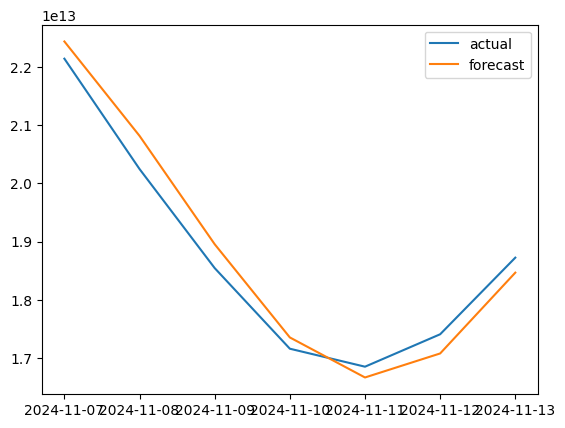

In [20]:
# Forecast the test set
forecast_duration = auto_model_duration.predict(n_periods=len(test_duration))
plt.plot(test_duration.index, test_duration, label='actual')
plt.plot(test_duration.index, forecast_duration, label='forecast')
plt.legend()
plt.show()

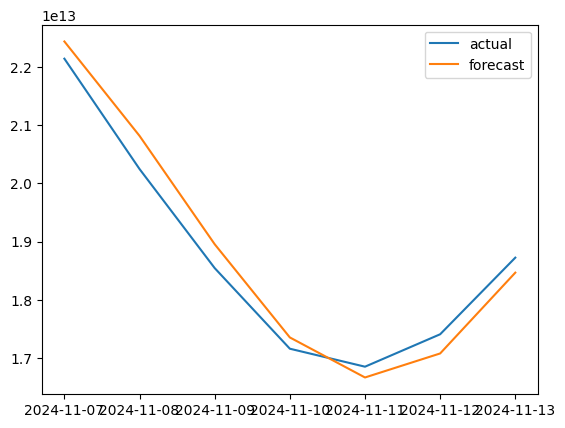

In [21]:
forecast_duration = pd.to_timedelta(forecast_duration)

plt.plot(test_duration.index, test_duration, label='actual')
plt.plot(test_duration.index, forecast_duration, label='forecast')
plt.legend()
plt.show()

In [22]:

forecast_duration = pd.to_timedelta(forecast_duration)
print(forecast_duration)
print(test_duration)


mae_duration = mean_absolute_error(test_duration, forecast_duration)
mape_duration = mean_absolute_percentage_error(test_duration, forecast_duration)
mae_duration = pd.to_timedelta(mae_duration)
print(type(mae_duration))
print(f'Mean Absolute Error: {mae_duration}')
print(f'Mean Absolute Percentage Error: {mape_duration}')

2024-11-07   0 days 06:13:50.440202131
2024-11-08   0 days 05:46:51.623702514
2024-11-09   0 days 05:15:53.194070842
2024-11-10   0 days 04:49:14.590386911
2024-11-11   0 days 04:37:48.018297815
2024-11-12   0 days 04:44:40.011006817
2024-11-13   0 days 05:07:45.942874467
Freq: D, dtype: timedelta64[ns]
date
2024-11-07   0 days 06:08:55.338345864
2024-11-08   0 days 05:37:22.748091603
2024-11-09   0 days 05:09:03.772241992
2024-11-10   0 days 04:46:01.414790996
2024-11-11   0 days 04:40:53.071253071
2024-11-12   0 days 04:50:09.113924050
2024-11-13   0 days 05:12:03.116883116
Name: duration, dtype: timedelta64[ns]
<class 'pandas._libs.tslibs.timedeltas.Timedelta'>
Mean Absolute Error: 0 days 00:05:19.700681868
Mean Absolute Percentage Error: 1.6912789308921716


In [25]:
etc = daily_data.copy()
etc
lower_bound = etc['camera_1'].quantile(0.05)
upper_bound = etc['camera_1'].quantile(0.95)
outliers = (etc['camera_1'] <= lower_bound) | (etc['camera_1'] >= upper_bound)
ffill_values = etc['camera_1'].ffill()
bfill_values = etc['camera_1'].bfill()

mean_fill_values = (ffill_values + bfill_values) / 2
print((etc['camera_1']-mean_fill_values).sum())

data_with_external_five_percent_removed = etc[~outliers]['camera_1']
print(data_with_external_five_percent_removed)
# data_with_external_five_percent_removed.loc[outliers, 'camera_1'] = mean_fill_values[outliers]


0.0
date
2024-09-12    886
2024-09-13    809
2024-09-14    925
2024-09-16    843
2024-09-17    803
2024-09-18    940
2024-09-19    902
2024-09-20    789
2024-09-21    919
2024-09-22    859
2024-09-23    829
2024-09-24    831
2024-09-26    755
2024-09-27    784
2024-09-28    827
2024-09-29    905
2024-09-30    803
2024-10-03    843
2024-10-04    821
2024-10-05    803
2024-10-06    855
2024-10-07    863
2024-10-09    869
2024-10-10    821
2024-10-11    800
2024-10-12    851
2024-10-14    856
2024-10-15    823
2024-10-16    895
2024-10-17    785
2024-10-18    829
2024-10-19    771
2024-10-20    808
2024-10-21    868
2024-10-22    860
2024-10-23    857
2024-10-24    850
2024-10-25    799
2024-10-26    799
2024-10-27    844
2024-10-28    829
2024-10-29    879
2024-10-30    867
2024-11-01    908
2024-11-02    864
2024-11-03    847
2024-11-04    893
2024-11-05    878
2024-11-06    902
2024-11-07    807
2024-11-08    798
2024-11-09    906
2024-11-11    828
2024-11-12    806
2024-11-13    781
N

In [26]:
train_duration = data_with_external_five_percent_removed[:47]
test_duration = data_with_external_five_percent_removed[47:]
print(data_with_external_five_percent_removed.shape)

(55,)


In [27]:
from pmdarima import auto_arima
auto_model_duration = auto_arima(train_duration,
                        # start_p=0, max_p=14,    # Range of values for p
                        # start_q=0, max_q=14,    # Range of values for q
                        p = None,               # Let auto_arima determine the best p
                        q = None,               # Let auto_arima determine the best q
                        d = 0,                # Let auto_arima determine the best d
                        seasonal=True,         # Enable seasonal differencing
                        m=7,                   # Weekly seasonality
                        # start_P=0, max_P=14,    # Range of values for seasonal P
                        # start_Q=0, max_Q=14,    # Range of values for seasonal Q
                        P=None,                # Let auto_arima determine the best P
                        Q=None,                # Let auto_arima determine the best Q

                        D=None,                # Let auto_arima determine the best D
                        trace=True,            # Print results for each model tested
                        # error_action='ignore', # Ignore models that don’t fit
                        suppress_warnings=True,
                        stepwise=True)         # Stepwise search for faster execution

# Display the best model found
print(auto_model_duration.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=500.090, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=489.120, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=493.098, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=493.086, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=768.879, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=491.258, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=491.097, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=493.097, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=491.103, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=491.103, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=493.097, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7] intercept
Total fit time: 1.553 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   47
Model: 

In [28]:
auto_model_duration.predict(n_periods=len(test_duration))

/home/balaji/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/balaji/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


47    843.957447
48    843.957447
49    843.957447
50    843.957447
51    843.957447
52    843.957447
53    843.957447
54    843.957447
dtype: float64

In [29]:
test_duration

date
2024-11-05    878
2024-11-06    902
2024-11-07    807
2024-11-08    798
2024-11-09    906
2024-11-11    828
2024-11-12    806
2024-11-13    781
Name: camera_1, dtype: int64

In [30]:
mean_absolute_percentage_error(auto_model_duration.predict(n_periods=len(test_duration)), test_duration)

/home/balaji/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/balaji/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


5.241894821761706

/home/balaji/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/balaji/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


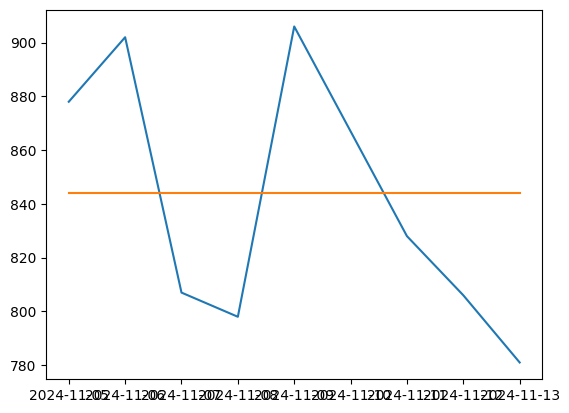

In [31]:
plt.plot(test_duration.index, test_duration, label='actual')
plt.plot(test_duration.index, auto_model_duration.predict(n_periods=len(test_duration)), label='forecast')

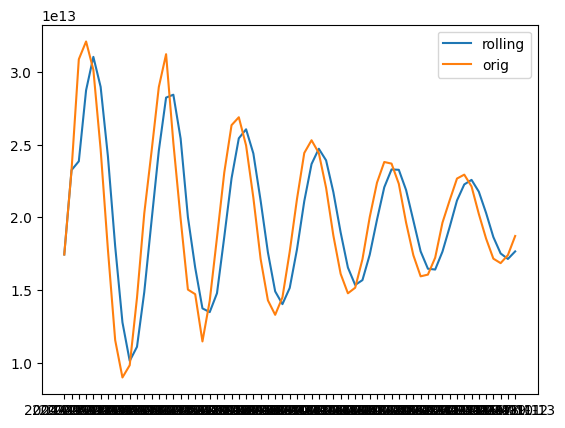

In [32]:
grouped_duration_by_date = combined_car_data.groupby('date').agg({'duration': 'mean'})
window=3
rolling_grouped_data=(grouped_duration_by_date['duration']/np.timedelta64(1,'ns')).astype(np.float64).rolling(window=window).mean()
rolling_grouped_data.iloc[:window-1]=(grouped_duration_by_date['duration']/np.timedelta64(1,'ns')).astype(np.float64).iloc[:window-1]
plt.plot(rolling_grouped_data, label='rolling')
plt.plot(grouped_duration_by_date['duration'], label='orig')
plt.legend()

In [33]:
(grouped_duration_by_date['duration']/np.timedelta64(1,'ns')).astype(np.float64)

date
2024-09-12    1.744805e+13
2024-09-13    2.326258e+13
2024-09-14    3.089406e+13
2024-09-15    3.211970e+13
2024-09-16    3.016918e+13
                  ...     
2024-11-09    1.854377e+13
2024-11-10    1.716141e+13
2024-11-11    1.685307e+13
2024-11-12    1.740911e+13
2024-11-13    1.872312e+13
Name: duration, Length: 63, dtype: float64

In [34]:
train_duration = rolling_grouped_data[:56]
test_duration = rolling_grouped_data[56:]

In [35]:
from pmdarima import auto_arima
auto_model_duration = auto_arima(train_duration,
                        # start_p=0, max_p=14,    # Range of values for p
                        # start_q=0, max_q=14,    # Range of values for q
                        p = None,               # Let auto_arima determine the best p
                        q = None,               # Let auto_arima determine the best q
                        d = 0,                # Let auto_arima determine the best d
                        seasonal=True,         # Enable seasonal differencing
                        m=7,                   # Weekly seasonality
                        # start_P=0, max_P=14,    # Range of values for seasonal P
                        # start_Q=0, max_Q=14,    # Range of values for seasonal Q
                        P=None,                # Let auto_arima determine the best P
                        Q=None,                # Let auto_arima determine the best Q

                        D=None,                # Let auto_arima determine the best D
                        trace=True,            # Print results for each model tested
                        # error_action='ignore', # Ignore models that don’t fit
                        suppress_warnings=True,
                        stepwise=True)         # Stepwise search for faster execution

# Display the best model found
print(auto_model_duration.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=3432.840, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=3365.604, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=3394.835, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=3594.965, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=3373.264, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=3346.808, Time=0.94 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=3348.807, Time=1.94 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=3376.812, Time=0.35 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=3436.237, Time=2.15 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=3271.793, Time=3.94 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=3269.876, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=3267.880, Time=0.07 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=3269.421, Time=0.08 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : 

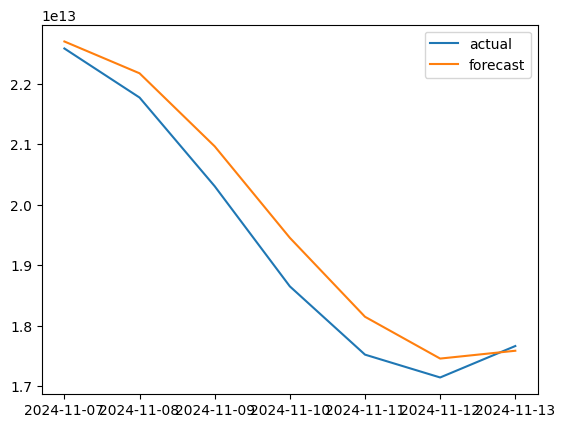

In [36]:
# Forecast the test set
forecast_duration = auto_model_duration.predict(n_periods=len(test_duration))
forecast_duration = pd.to_timedelta(forecast_duration)
plt.plot(test_duration.index, test_duration, label='actual')
plt.plot(test_duration.index, forecast_duration, label='forecast')
plt.legend()
plt.show()


In [37]:
forecast_duration = pd.to_timedelta(forecast_duration)
test_duration = pd.to_timedelta(test_duration)
print(forecast_duration)
print(test_duration)


mae_duration = mean_absolute_error(test_duration, forecast_duration)
mape_duration = mean_absolute_percentage_error(test_duration, forecast_duration)
mae_duration = pd.to_timedelta(mae_duration)
print(type(mae_duration))
print(f'Mean Absolute Error: {mae_duration}')
print(f'Mean Absolute Percentage Error: {mape_duration}')


2024-11-07   0 days 06:18:23.485309469
2024-11-08   0 days 06:09:36.830144009
2024-11-09   0 days 05:49:27.599161483
2024-11-10   0 days 05:24:13.241147866
2024-11-11   0 days 05:02:26.198946729
2024-11-12   0 days 04:50:54.165033265
2024-11-13   0 days 04:53:03.631535506
Freq: D, dtype: timedelta64[ns]
date
2024-11-07   0 days 06:16:27.536168383
2024-11-08   0 days 06:02:55.350079457
2024-11-09   0 days 05:38:27.286226486
2024-11-10   0 days 05:10:49.311708197
2024-11-11   0 days 04:51:59.419428686
2024-11-12   0 days 04:45:41.199989372
2024-11-13   0 days 04:54:21.767353412
Name: duration, dtype: timedelta64[ns]
<class 'pandas._libs.tslibs.timedeltas.Timedelta'>
Mean Absolute Error: 0 days 00:07:08.507422878
Mean Absolute Percentage Error: 2.2521830821676914
